In [3]:
import os
import fsspec
import numpy as np
import pandas as pd
import swifter
swifter.set_defaults(
    npartitions=None,
    dask_thres=1,
    scheduler='processes',
    progress_bar=True,
    progress_bar_desc=None,
    allow_dask_on_strings=True,
    force_parallel=False
)
import sklearn as skl
import sklearn.base
import sklearn.compose
import sklearn.feature_extraction
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
import sklearn.pipeline
import tensorflow as tf
from tensorflow import keras as keras
import tensorflow_addons as tfa
import scikeras as skeras
import scikeras.wrappers
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import joblib
import string
import pickle

2022-12-20 16:44:51.272576: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
session_storage = 'downloads'
os.makedirs(session_storage, exist_ok=True)

In [5]:
fs_dataset = fsspec.filesystem(
    'simplecache', 
    target_protocol='https', 
    cache_storage=session_storage
)

In [6]:
def set_constrained_layout(plt):
    plt.rcParams['figure.constrained_layout.use'] = True
set_constrained_layout(plt)

plt.style.use('default')

In [7]:
def subplots(
    n, 
    ncols = 1, visible = False, 
    *args, **kwargs
):
    fig, axs = plt.subplots(
        *args, **kwargs,
        ncols=ncols, 
        nrows=int(np.ceil(n / ncols))
    )
    for ax in axs.flatten():
        ax.set(visible=visible)
    return fig, axs

# Dataset

In [16]:
df_scripts = pd.read_pickle('./dataset.pkl', compression='gzip')
df_scripts

,movie_name,script_text
0,Reservoir Dogs,[\r\n\r\n\r\n\r\n\r\n\r\n ...
1,How to Train Your Dragon,[\r\n\r\n\r\n HOW T...
2,Scream,[ \r\n ...
3,Groundhog Day,[\r\n\r\n \r\n ...
4,Black Panther,[\r\n\r\n\r\n \r\n BL...
...,...,...
1204,You've Got Mail,[\r\n\r\nYou've Got Mail\r\n\r\n\r\n\r\n\t\t\t...
1205,Youth in Revolt,[ \r\n \r\n\r\n ...
1206,Zero Dark Thirty,[\r\n\r\n \r\n ...
1207,Zerophilia,[\r\n\r\n\r\n\r\n ...


### Preprocessing

In [17]:
df_scripts = df_scripts.astype({
    'movie_name': 'category'
})
df_scripts = df_scripts.explode('script_text', ignore_index=True)
df_scripts.dropna(inplace=True)
df_scripts.reset_index(drop=True, inplace=True)
df_scripts

,movie_name,script_text
0,Reservoir Dogs,\r\n\r\n\r\n\r\n\r\n\r\n ...
1,How to Train Your Dragon,\r\n\r\n\r\n HOW TO...
2,Scream,\r\n ...
3,Groundhog Day,\r\n\r\n \r\n ...
4,Black Panther,\r\n\r\n\r\n \r\n BLA...
...,...,...
1172,You've Got Mail,\r\n\r\nYou've Got Mail\r\n\r\n\r\n\r\n\t\t\tY...
1173,Youth in Revolt,\r\n \r\n\r\n ...
1174,Zero Dark Thirty,\r\n\r\n \r\n ...
1175,Zerophilia,\r\n\r\n\r\n\r\n ...


## Feature Engineering

In [19]:
def str_normalize_eol(s, eol=os.linesep):
    return str.join(eol, str.splitlines(s))

In [20]:
class ParagraphExtractor(skl.base.TransformerMixin):
    def __init__(self,
        eol=os.linesep,
        eol_freq_min=2,
        n_jobs=1
    ):
        self.eol = eol
        self.eol_freq_min = eol_freq_min
        self.n_jobs = n_jobs

        self._pattern = re.compile(
            fr'(?:{self.eol}\s*?){{{self.eol_freq_min},}}'
        )

    def fit(self, _X, _y=None):
        return self

    def transform(self, X, _y=None):
        def _impl_single(s):
            nonlocal self
            return re.split(
                self._pattern,
                str_normalize_eol(s, eol=self.eol)
            )

        return joblib.Parallel(n_jobs=self.n_jobs)(
            joblib.delayed(_impl_single)(s)
                for s in X
        )

        
df_scripts['script_paragraphs'] = ParagraphExtractor(n_jobs=-1).fit_transform(
    df_scripts['script_text']#.iloc[:100]
)

df_scripts_para = (
    df_scripts[['movie_name', 'script_paragraphs']]
        .explode('script_paragraphs', ignore_index=True)
)

df_scripts_para['script_paragraphs'] = (
    df_scripts_para['script_paragraphs'].str.strip()
)

df_scripts_para = df_scripts_para[
    # non-empty strings
    df_scripts_para['script_paragraphs'].astype(bool)
]

df_scripts_para['movie_name'] = (
    df_scripts_para['movie_name']
        .cat.remove_unused_categories()
)

/Users/franklinle/Desktop/movie_prediction_model/movie-env/lib/python3.8/site-packages/swifter/swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(
/Users/franklinle/Desktop/movie_prediction_model/movie-env/lib/python3.8/site-packages/swifter/swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(
/Users/franklinle/Desktop/movie_prediction_model/movie-env/lib/python3.8/site-packages/swifter/swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(
/Users/franklinle/Desktop/movie_prediction_model/movie-env/lib/python3.8/site-packages/swifter/swifter.

In [21]:
df_scripts_para

,movie_name,script_paragraphs
1,Reservoir Dogs,Quentin Tarantino's
2,Reservoir Dogs,R E S E R V O I R D O G S
3,Reservoir Dogs,"October 22, 1990"
4,Reservoir Dogs,-----------------
5,Reservoir Dogs,This movie is dedicated to these following sou...
...,...,...
1999878,Zootopia,NICK\n Flash? Flash? Hundred yard dash?!
1999879,Zootopia,Yep. It's Flash the sloth.
1999880,Zootopia,FLASH\n (several beats)\n ...
1999881,Zootopia,CUT TO BLACK:


In [22]:
import string

def _str_letters(s):
    return s.translate(
        str.maketrans(
            '', '', 
            string.punctuation + string.whitespace
        )
    )

def _df_lower_letters(df):
    return _str_letters(df.str).str.lower()

df_scripts_para = df_scripts_para[
    _df_lower_letters(df_scripts_para['movie_name'])
        != _df_lower_letters(df_scripts_para['script_paragraphs'])
]

In [150]:
# Script divided into one-to-many relationship dataset
df_scripts_para

,movie_name,script_paragraphs
1,Reservoir Dogs,Quentin Tarantino's
3,Reservoir Dogs,"October 22, 1990"
4,Reservoir Dogs,-----------------
5,Reservoir Dogs,This movie is dedicated to these following sou...
6,Reservoir Dogs,inspiration:
...,...,...
1999878,Zootopia,NICK\n Flash? Flash? Hundred yard dash?!
1999879,Zootopia,Yep. It's Flash the sloth.
1999880,Zootopia,FLASH\n (several beats)\n ...
1999881,Zootopia,CUT TO BLACK:


count    1126.000000
mean     1691.282416
std       543.039628
min         1.000000
25%      1470.250000
50%      1724.500000
75%      1954.750000
max      5265.000000
Name: script_paragraphs, dtype: float64


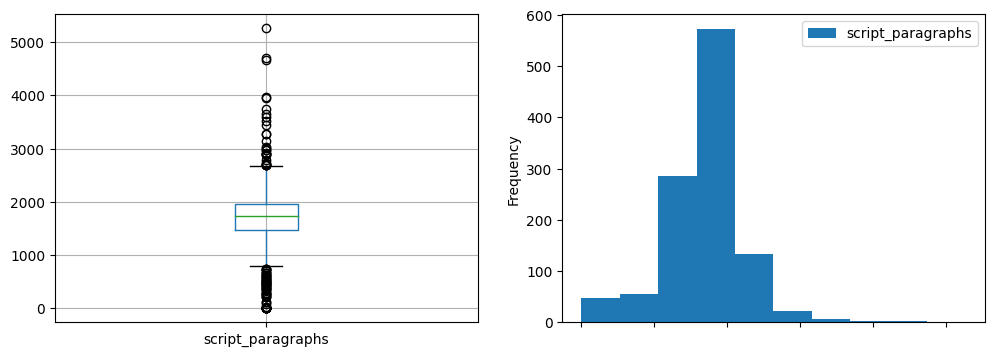

In [198]:
# Movie to Paragraph Count
df_n_paras = df_scripts_para.groupby('movie_name').count()
# print(df_n_paras)
print(df_n_paras["script_paragraphs"].describe())

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# All Movie Script Paragraph Distribution
distribution = df_n_paras.plot.hist(ax=ax[1])

# Set the x-axis tick labels to an empty list
distribution.set_xticklabels([])

# All Movies Script Paragraph Boxplot
boxplot = df_n_paras.boxplot(column='script_paragraphs', ax=ax[0])

In [250]:
# Determine and Remove Outliers
# IQR is 1954.75 - 1470.25 = 484.50
# lower whisker is 1470.25 - (1.5 * 484.50) = 821.25
# upper whisker is 1954.75 + (1.5 * 484.50) = 2706.75

df_scripts_outliers = df_scripts_para[
    df_scripts_para['movie_name'].isin(
        df_n_paras[(df_n_paras['script_paragraphs'] < 821.25) | (df_n_paras['script_paragraphs'] > 2700)].index
    )
]

# Before
print(df_scripts_para.shape)

# Remove Outlieres
df_scripts_para_ = df_scripts_para.drop(df_scripts_outliers.index)

# After
print(df_scripts_para_.shape)

(1904384, 2)
(1795523, 2)


count    1034.000000
mean     1736.482592
std       344.556783
min       828.000000
25%      1513.250000
50%      1740.000000
75%      1953.750000
max      2699.000000
Name: script_paragraphs, dtype: float64


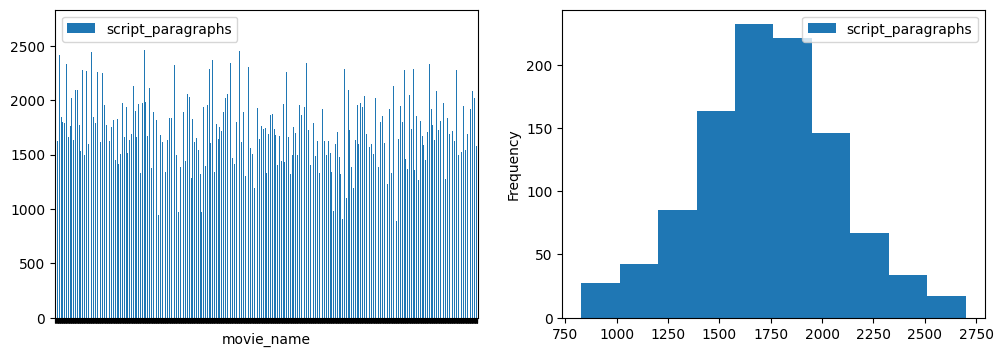

In [251]:
df_filtered = df_n_paras[(df_n_paras['script_paragraphs'] >= 821.25) & (df_n_paras['script_paragraphs'] <= 2706.75)]

print(df_filtered["script_paragraphs"].describe())

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

filtered_distribution = df_filtered.plot(kind="bar", ax=ax[0])

filtered_distribution.set_xticklabels([])

filtered_histogram = df_filtered.plot.hist(column='script_paragraphs', ax=ax[1])

#### Models
#### Neural Network (LSTM RNN)
#### Text Transformers
#### Classifier

In [201]:
class KerasTextClassifier(
    skl.base.BaseEstimator,
    skl.base.ClassifierMixin
):
    def __init__(self, 
        batch_size=128,
        epochs=1,
        optimizer='adam',
        verbose='auto',
        callbacks=[]
    ):
        super().__init__()

        self.batch_size = batch_size
        self.epochs = epochs

        self.optimizer = optimizer

        self.verbose = verbose
        self.callbacks = callbacks

    def _default_kwargs(self, kwargs):
        return {
            'verbose': self.verbose,
            **kwargs,
            'callbacks': 
                kwargs.get('callbacks', []) 
                    + self.callbacks
        }
        
    def fit(self, X, y, vocabulary=None, **kwargs):
        loss = 'sparse_categorical_crossentropy'

        self.target_encoder = (
            skeras.utils.transformers.ClassifierLabelEncoder(
                loss=loss
            )
        )
        self.target_encoder = self.target_encoder.fit(y)

        self.feature_encoder = (
            keras.layers.TextVectorization(
                output_mode='int',
                vocabulary=vocabulary,
                ragged=True
            )
            )
        if vocabulary is None:
            self.feature_encoder.adapt(X)

        self.base = keras.Sequential([
            self.feature_encoder,

            keras.layers.Embedding(
                input_dim=self.feature_encoder.vocabulary_size(),
                output_dim=128,
                #mask_zero=True
            ),

            #keras.layers.SpatialDropout1D(.2),

            keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(64)),

            keras.layers.Dense(128, activation='relu'),

            keras.layers.Dense(
                units=len(self.target_encoder.classes_),
                activation='softmax'
            )
        ])

        self.base.compile(
            optimizer=self.optimizer,
            loss=loss,
            metrics=['accuracy']
        )
        y = self.target_encoder.transform(y)
        self.base.fit(
            X, y, 
            **{
                'epochs': self.epochs,
                'batch_size': self.batch_size,
                **self._default_kwargs(kwargs)
            }
        )

        return self
        
    def predict(self, X, **kwargs):
        y = self.base.predict(X, **{
            'batch_size': self.batch_size,
            **self._default_kwargs(kwargs)
        })
        return self.target_encoder.inverse_transform(y)

    def score(self, X, y, sample_weight=None, **kwargs):
        y_pred = self.predict(X, **kwargs)
        return skl.metrics.balanced_accuracy_score(y, y_pred)

# Predictor (Vocab From Spacy)

In [203]:
def get_vocabulary(X, **kwargs):
    v = keras.layers.TextVectorization(**kwargs)
    v.adapt(X)
    return v.get_vocabulary()

class TextClassifierCV(
    skl.base.BaseEstimator,
    skl.base.ClassifierMixin
):
    def __init__(self, 
        options_vectorizer=dict(),
        options_clf=dict(),
        options_gridsearch=dict()
    ):
        super().__init__()
        self.options_vectorizer = options_vectorizer
        self.options_clf = options_clf
        self.options_gridsearch = options_gridsearch

    def fit(self, X, y, **kwargs):
        self.base = (
            skl.model_selection.GridSearchCV(
                KerasTextClassifier(
                    **self.options_clf,
                ),
                **self.options_gridsearch,
                param_grid={
                    'epochs': [50],
                    'batch_size': [512]
                },
                cv=skl.model_selection.RepeatedStratifiedKFold(
                    n_splits=3, n_repeats=1
                )
            )
                .fit(X, y, 
                    vocabulary=get_vocabulary(X), 
                    **kwargs
                )
        )

        return self

    def best_estimator(self):
        return self.base.best_estimator_

    def best_score(self):
        return self.base.best_score_

In [204]:
class IMSDBParagraphTrainer:
    def __init__(self, 
        col_name='movie_name', 
        col_script_paragraphs='script_paragraphs',
        options_clf=dict(),
        options_gridsearch=dict()
    ):
        self.col_name = col_name
        self.col_script_paragraphs = col_script_paragraphs

        self.base = TextClassifierCV(
            options_vectorizer=dict(
                max_tokens=None,
                standardize='lower_and_strip_punctuation',
                split='whitespace',
                #ngrams=(1, 2),
                #output_sequence_length=64
            ),
            options_clf=dict(
                **options_clf,
            ),
            options_gridsearch=dict(
                refit=True,
                **options_gridsearch
            )
        )

    def fit(self, df: pd.DataFrame, **kwargs):
        self.base = self.base.fit(
            X=np.array(df[self.col_script_paragraphs]),
            y=np.array(df[self.col_name]),
            **kwargs
        )
        return self

    def best_estimator(self):
        return self.base.best_estimator()

    def best_score(self):
        return self.base.best_score()

In [205]:
model = IMSDBParagraphTrainer(
    options_clf=dict(
        verbose=0,
        callbacks=[
            tfa.callbacks.TQDMProgressBar(
                show_epoch_progress=False
            )
            #keras.callbacks.EarlyStopping(
            #    monitor='loss', 
            #    patience=3, 
            #    min_delta=0.0001
            #)
        ]
    ),
    options_gridsearch=dict(
        verbose=3,
        error_score='raise',
        #n_jobs=-1
    )
)